In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [4]:
import scanpy as sc

# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l2'] = adata.obs['celltype.l2'].str.replace(' ', '_')
label = adata.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


In [5]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4 T,CD4_TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8 T,CD8_Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8 T,CD8_Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## Read features

In [6]:
import os
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\feature_selection_k2")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/feature_selection_k2')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [7]:
features_dict.keys()

dict_keys(['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC'])

In [8]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
ASDC,45,22
B_intermediate,16,6
B_memory,41,18
B_naive,9,6
CD14_Mono,17,9
CD16_Mono,12,4
CD4_CTL,129,46
CD4_Naive,131,75
CD4_Proliferating,20,13
CD4_TCM,88,48


## Build classifiers (K-fold CV)

In [8]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring, n_jobs=32)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [ ]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    # filename = f'LR_{celltype}_Harmony_l1.pkl'
    # with open(filename, 'wb') as f:
    #     pickle.dump(clf, f)


K-fold CV for: ASDC
[0.99993818116626, 0.9733333333333334, 0.8933333333333333, 0.9287709991158268, 0.9999847443933676, 0.9743086741999155, 0.9310108782849277]
K-fold CV for: B_intermediate
[0.9898061372960978, 0.7331895244349341, 0.5092394013908959, 0.5971266803839372, 0.9920593833356867, 0.6852329094287961, 0.6041902096935683]
K-fold CV for: B_memory
[0.9963836198182004, 0.9211871235340545, 0.8995433789954337, 0.9096834950937677, 0.9987942286567713, 0.9651610560001693, 0.908193248520363]
K-fold CV for: B_naive
[0.9955305254921119, 0.9534820414317429, 0.953095796157811, 0.9531389502837166, 0.9993741548836358, 0.986596032273247, 0.9508751244535976]
K-fold CV for: CD14_Mono
[0.9895835882335083, 0.9766247453105776, 0.9841180604356993, 0.9803409377412906, 0.9987258480849898, 0.9943096520777616, 0.9732839596279058]
K-fold CV for: CD16_Mono
[0.993583253248055, 0.9166108037935624, 0.9200949367088608, 0.9182198506904587, 0.9985508253058804, 0.9538452242784106, 0.9149528036190355]
K-fold CV for

In [10]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,0.999938,0.973333,0.893333,0.928771,0.999985,0.974309,0.931011
B_intermediate,0.989806,0.733190,0.509239,0.597127,0.992059,0.685233,0.604190
B_memory,0.996384,0.921187,0.899543,0.909683,0.998794,0.965161,0.908193
B_naive,0.995531,0.953482,0.953096,0.953139,0.999374,0.986596,0.950875
CD14_Mono,0.989584,0.976625,0.984118,0.980341,0.998726,0.994310,0.973284
CD16_Mono,0.993583,0.916611,0.920095,0.918220,0.998551,0.953845,0.914953
CD4_CTL,0.996606,0.868887,0.808205,0.836208,0.997880,0.918503,0.835687
CD4_Naive,0.971347,0.873198,0.865153,0.868152,0.991548,0.935510,0.852730
CD4_Proliferating,0.999679,0.815571,0.722944,0.745707,0.999288,0.852597,0.757076
CD4_TCM,0.963305,0.820968,0.782454,0.797415,0.986870,0.877548,0.779866


In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\LR_likelihood")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/LR_likelihood')
# save metrics
all_metrics.index = types
all_metrics.to_csv('LR_metrics_L2_k2.csv')

## Plot classifier K-fold CV metrics

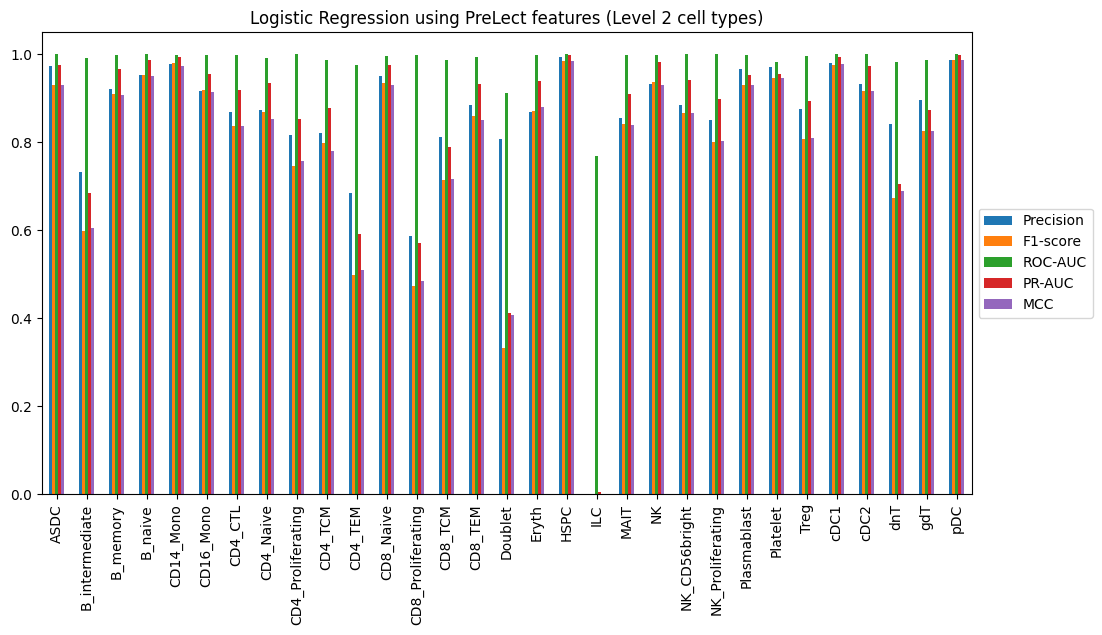

In [12]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']

# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=90, figsize=(12,6), title='Logistic Regression using PreLect features (Level 2 cell types)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Get likelihood from LR model

In [13]:
def LR_likelihood_pred_prob(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000, n_jobs=32)
    clf.fit(X_train, y_train)

    # likelihood of the positive class for each observation
    likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個

    return likelihood


In [14]:
celltype = 'ASDC'
B_likelihood = LR_likelihood_pred_prob(adata, features_dict, celltype)
B_likelihood.shape

Celltype: ASDC
likelihood > 0.5: 74


(161764,)

In [15]:
B_likelihood[:5]

array([4.05079449e-06, 3.69633546e-09, 3.35965008e-08, 2.67549105e-08,
       3.12576793e-09])

In [16]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = LR_likelihood_pred_prob(adata, features_dict, celltype)

Celltype: ASDC
likelihood > 0.5: 74
Celltype: B_intermediate
likelihood > 0.5: 1627
Celltype: B_memory
likelihood > 0.5: 3214
Celltype: B_naive
likelihood > 0.5: 7745
Celltype: CD14_Mono
likelihood > 0.5: 43045
Celltype: CD16_Mono
likelihood > 0.5: 6337
Celltype: CD4_CTL
likelihood > 0.5: 1614
Celltype: CD4_Naive
likelihood > 0.5: 17331
Celltype: CD4_Proliferating
likelihood > 0.5: 102
Celltype: CD4_TCM
likelihood > 0.5: 14254
Celltype: CD4_TEM
likelihood > 0.5: 2524
Celltype: CD8_Naive
likelihood > 0.5: 10370
Celltype: CD8_Proliferating
likelihood > 0.5: 65
Celltype: CD8_TCM
likelihood > 0.5: 2286
Celltype: CD8_TEM
likelihood > 0.5: 11137
Celltype: Doublet
likelihood > 0.5: 152
Celltype: Eryth
likelihood > 0.5: 90
Celltype: HSPC
likelihood > 0.5: 323
Celltype: ILC
likelihood > 0.5: 0
Celltype: MAIT
likelihood > 0.5: 2712
Celltype: NK
likelihood > 0.5: 17353
Celltype: NK_CD56bright
likelihood > 0.5: 910
Celltype: NK_Proliferating
likelihood > 0.5: 496
Celltype: Plasmablast
likelihood >

In [17]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

,ASDC,B_intermediate,B_memory,B_naive,CD14_Mono,CD16_Mono,CD4_CTL,CD4_Naive,CD4_Proliferating,CD4_TCM,...,NK_CD56bright,NK_Proliferating,Plasmablast,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC
0,4.050794e-06,0.000009,8.223453e-06,0.000006,9.763964e-01,0.001657,2.856430e-08,2.534246e-08,3.019409e-05,0.000432,...,1.314255e-07,9.381009e-06,0.000013,0.000659,3.114388e-07,9.322597e-08,8.384308e-05,0.000008,0.000002,1.394708e-07
1,3.696335e-09,0.000228,1.826354e-04,0.000019,7.665299e-07,0.000004,2.211860e-06,1.905273e-02,1.883072e-04,0.958040,...,1.911380e-04,3.300470e-07,0.000002,0.000315,6.466321e-04,6.119334e-07,7.612749e-09,0.000137,0.000762,3.085681e-07
2,3.359650e-08,0.000099,6.297398e-06,0.000007,2.655943e-08,0.000008,7.838102e-06,2.519615e-02,1.368773e-06,0.000599,...,1.931318e-05,3.314322e-07,0.000002,0.000247,1.447316e-02,3.975406e-07,3.587770e-08,0.000225,0.004987,6.646975e-07
3,2.675491e-08,0.000052,3.685114e-07,0.000006,2.705006e-06,0.000324,2.120534e-06,7.366276e-07,9.203541e-08,0.000001,...,1.980422e-05,9.405887e-05,0.000007,0.000310,4.989004e-07,5.219693e-07,5.625754e-09,0.000003,0.015241,3.755735e-05
4,3.125768e-09,0.000121,6.498758e-05,0.000001,7.962159e-08,0.000134,2.687261e-07,2.824509e-03,1.070296e-05,0.000472,...,2.509767e-05,1.177242e-07,0.000005,0.000317,3.606605e-04,4.072744e-07,2.089452e-08,0.000865,0.001293,4.581587e-07


In [18]:
likelihood_df.shape

(161764, 31)

In [19]:
# row sum
likelihood_df.sum(axis=1)


0         0.981189
1         0.999468
2         1.104650
3         1.021000
4         1.066790
            ...   
161759    1.109015
161760    1.004464
161761    0.981606
161762    0.942498
161763    0.959291
Length: 161764, dtype: float64

In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\LR_likelihood")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/LR_likelihood')
likelihood_df.to_csv('L2_likelihood_df_k2.csv')

## Assign the celltype with the largest likelihood (no odds ratio)

In [21]:
largest_values = []
largest_columns = []
assignments = []
for index, row in likelihood_df.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns, 'Assignment': assignments})
result_df.shape


(161764, 3)

In [22]:
result_df.head(20)

,Largest Value,Largest Column,Assignment
0,0.976396,CD14_Mono,CD14_Mono
1,0.958040,CD4_TCM,CD4_TCM
2,0.998503,CD8_Naive,CD8_Naive
3,0.998155,NK,NK
4,0.945958,CD8_Naive,CD8_Naive
5,0.989026,CD8_TEM,CD8_TEM
6,0.785592,CD14_Mono,CD14_Mono
7,0.802719,B_intermediate,B_intermediate
8,0.999916,NK,NK
9,0.982329,CD8_Naive,CD8_Naive


## Confusion heatmap

In [23]:
import pandas as pd

# Get the true labels
true_labels = adata.obs['celltype.l2'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
# cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [24]:
cm

Predicted,ASDC,B_intermediate,B_memory,B_naive,CD14_Mono,CD16_Mono,CD4_CTL,CD4_Naive,CD4_Proliferating,CD4_TCM,...,NK_CD56bright,NK_Proliferating,Plasmablast,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC
True,,,,,,,,,,,,,,,,,,,,,
ASDC,62,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,0,0,4
B_intermediate,0,1676,240,496,2,0,0,0,0,3,...,0,0,0,0,1,0,0,1,0,0
B_memory,0,141,3106,25,1,1,0,1,1,1,...,0,0,5,0,0,0,0,0,1,0
B_naive,0,121,57,7524,1,3,0,1,0,0,...,2,0,0,0,1,0,0,0,2,0
CD14_Mono,0,2,1,2,42411,190,0,1,1,1,...,0,1,3,11,3,0,45,1,0,1
CD16_Mono,0,0,1,0,370,5938,0,0,0,0,...,0,0,0,0,0,0,7,0,0,0
CD4_CTL,0,0,0,0,0,0,1608,1,0,7,...,0,0,0,0,0,0,0,0,1,0
CD4_Naive,0,0,0,0,0,0,0,16906,0,402,...,0,0,0,0,85,0,0,10,6,0
CD4_Proliferating,0,0,0,0,2,0,0,0,83,10,...,0,3,0,0,0,0,0,1,0,0


In [25]:
cm.to_csv('likelihood_assignment_confusion_matrix_k2.csv')

## Plot confusion matrix

In [3]:
import os
os.chdir('./LR_likelihood')
cm = pd.read_csv('likelihood_assignment_confusion_matrix_k2.csv', index_col=0)

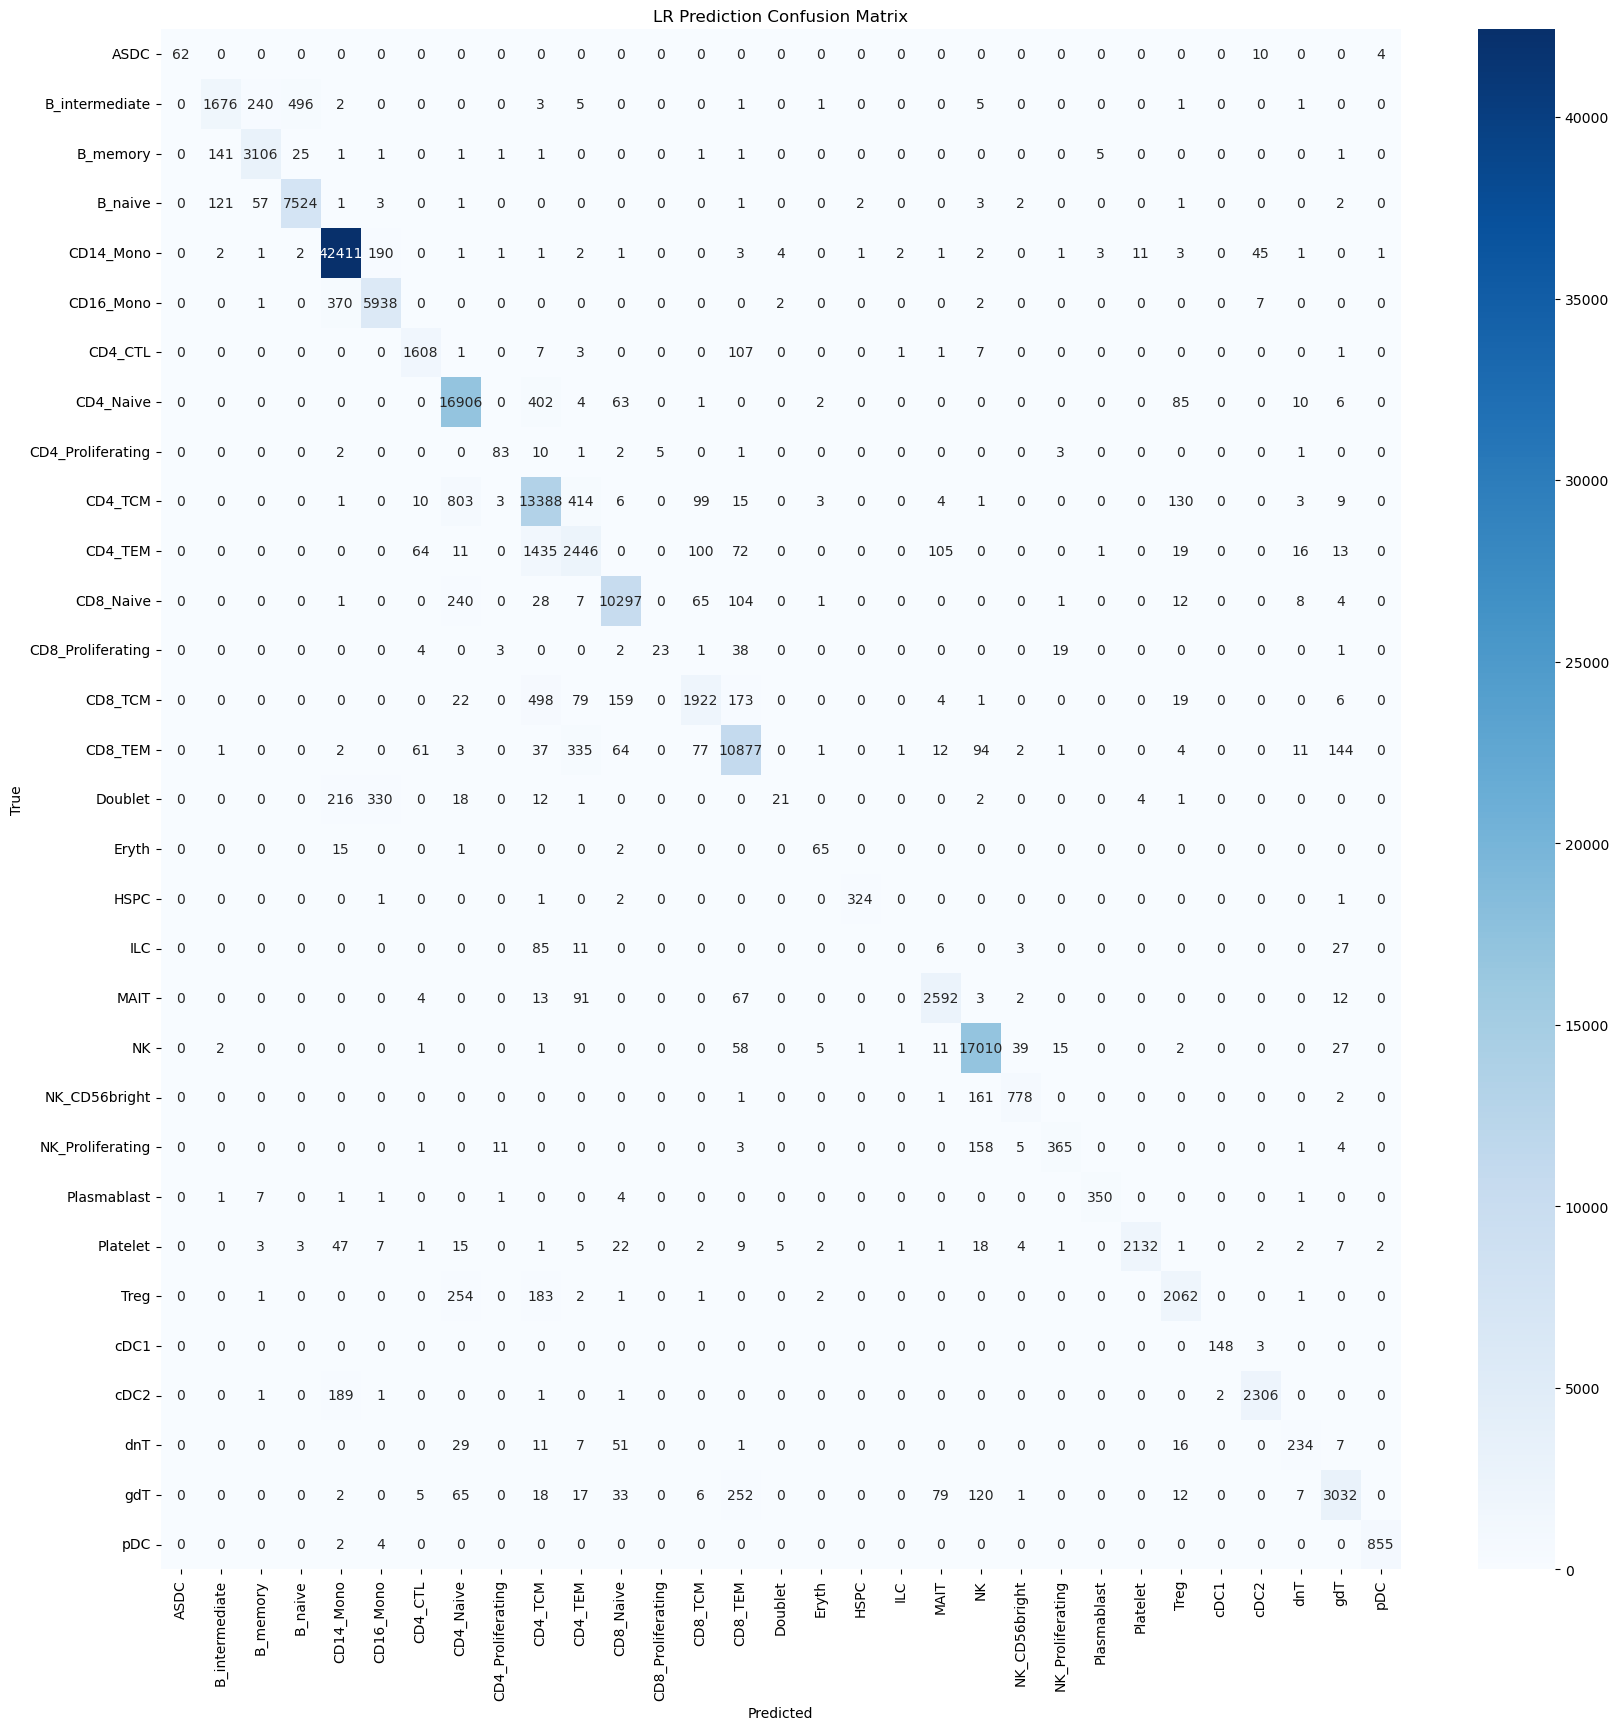

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [5]:
row_sum = cm.sum(axis=1)
row_sum


True
ASDC                    76
B_intermediate        2431
B_memory              3285
B_naive               7718
CD14_Mono            42690
CD16_Mono             6320
CD4_CTL               1736
CD4_Naive            17479
CD4_Proliferating      108
CD4_TCM              14889
CD4_TEM               4282
CD8_Naive            10768
CD8_Proliferating       91
CD8_TCM               2883
CD8_TEM              11727
Doublet                605
Eryth                   83
HSPC                   329
ILC                    132
MAIT                  2784
NK                   17173
NK_CD56bright          943
NK_Proliferating       548
Plasmablast            366
Platelet              2293
Treg                  2507
cDC1                   151
cDC2                  2501
dnT                    356
gdT                   3649
pDC                    861
dtype: int64

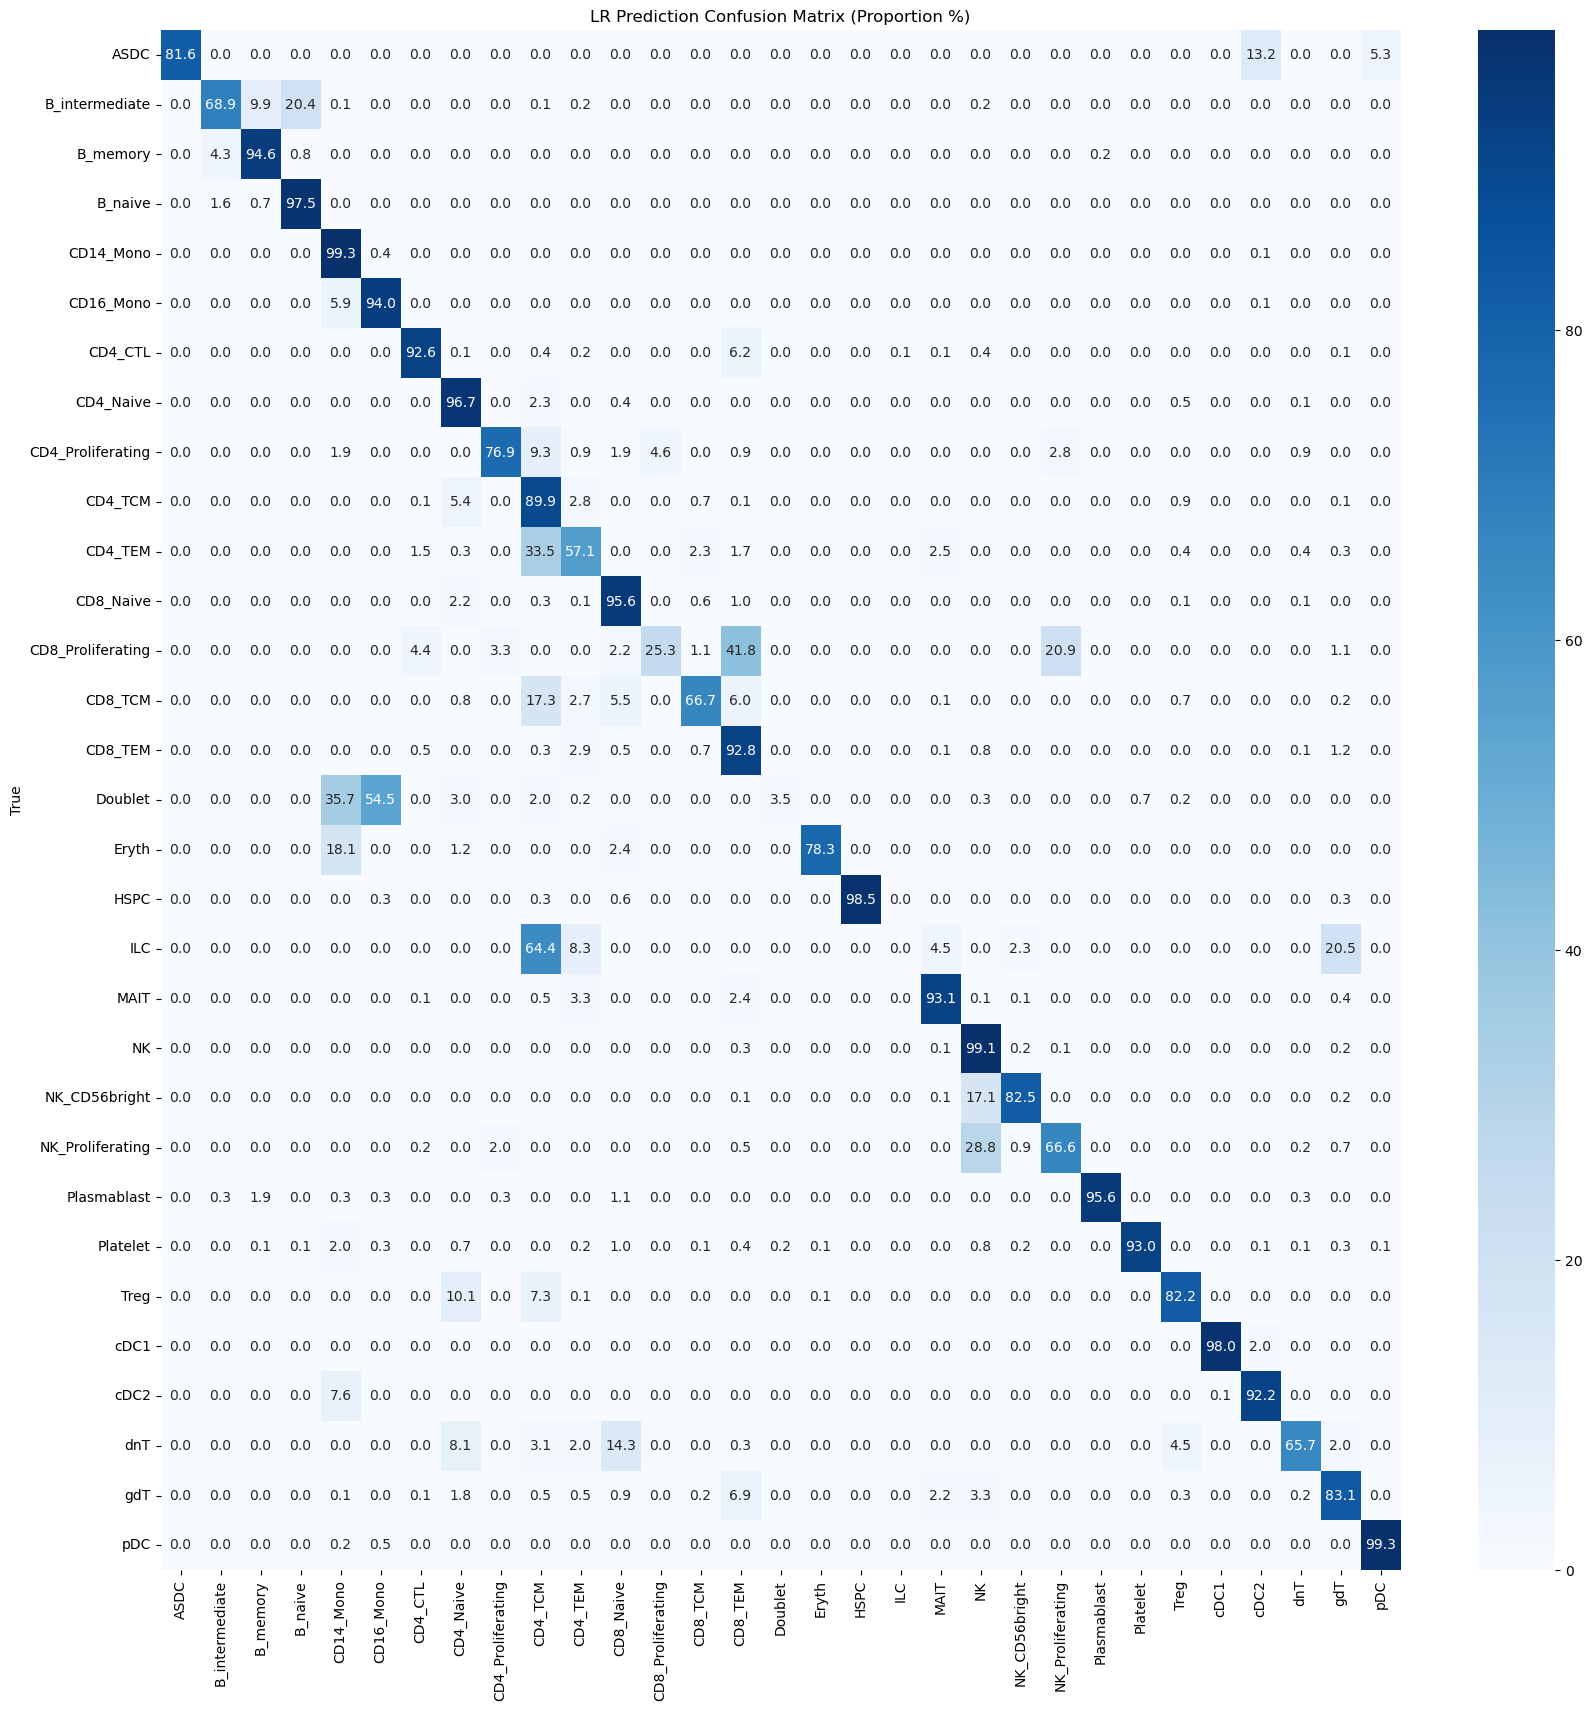

In [6]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(20, 20))
sns.heatmap(cm_proportion, fmt=".1f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.savefig('cm_plot.png', dpi=300)
plt.show()

## Calculate accuracy

In [7]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.9306211518013897

In [8]:
cm.values.sum()

161764